In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import investpy
import datetime
import plotly.express as px
from plotly.subplots import make_subplots

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

# Enable matplot widgets
%matplotlib widget

               Open     High      Low    Close  Volume Currency
Date                                                           
2004-09-01  1031.21  1059.25  1030.87  1047.86       0      USD
2004-10-01  1048.38  1075.42  1044.77  1072.70       0      USD
              Open    High     Low   Close  Volume Currency
Date                                                       
2004-09-01  440.27  467.71  440.04  464.15       0      USD
2004-10-01  464.86  482.63  462.42  474.27       0      USD
                Open
Date                
2004-09-01   913.022
2004-10-01   931.676
2004-11-01   955.104
2004-12-01  1004.666
2005-01-01  1042.898
...              ...
2020-05-01  1824.040
2020-06-01  1905.042
2020-07-01  1961.526
2020-08-01  2058.956
2020-09-01  2183.436

[193 rows x 1 columns]


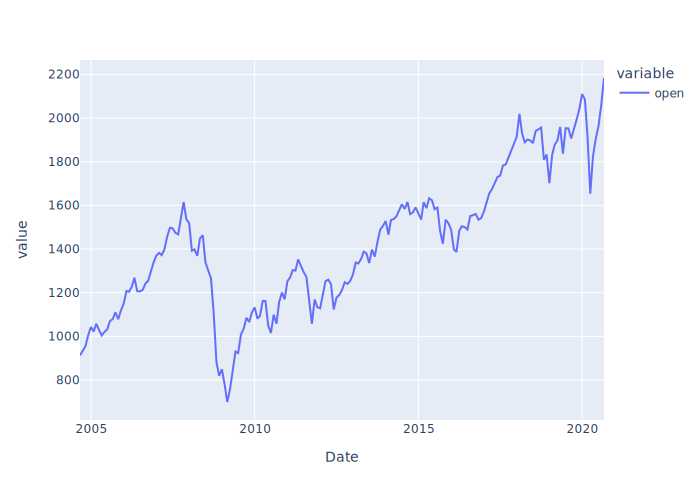

In [2]:
# Load the dataset

#i = 30
#anyos = 35
#df = investpy.get_index_historical_data(index="S&P 500",
#                                        country="united states",
#                                        from_date="01/09/"+str(1970+i),
#                                        to_date="01/09/"+str(1970+anyos+i),
#                                        interval='Monthly',
#                                        order="asc"
#                                   )

i = 0
anyos = 16
df1 = investpy.get_index_historical_data(index="MSCI World",
                                        country="world",
                                        from_date="01/09/"+str(2004+i),
                                        to_date="01/09/"+str(2004+anyos+i),
                                        interval='Monthly',
                                        order="asc"
                                   )
df2 = investpy.get_index_historical_data(index="MSCI Emerging Markets",
                                        country="world",
                                        from_date="01/09/"+str(2004+i),
                                        to_date="01/09/"+str(2004+anyos+i),
                                        interval='Monthly',
                                        order="asc"
                                   )

print(df1.head(2))
print(df2.head(2))
assert len(df1.index) == len(df2.index)
df = pd.DataFrame(index=df1.index)
df['Open'] = 0.8 * df1['Open'] + 0.2 * df2['Open']

print(df)

df_plot = pd.DataFrame(index=df.index)
df_plot['open'] = df['Open']
fig = px.line(df_plot)
fig.show('svg')

In [3]:
t = np.linspace(1,len(df.index),len(df.index))
index_rate = df['Open']/df['Open'][0] - 1


def corregir(x):
    if x > -0.02: return 0
    elif x > -0.1: return 200
    else: return 400

correcciones = index_rate.apply(corregir)

aportacion_inicial = 5000
aportaciones_periodicas = { "tiempo": 2, "cantidad": 500 }
aportaciones_periodicas_restantes = 300
tiempo_restante = ( len(df.index)/12 ) - aportaciones_periodicas['tiempo']


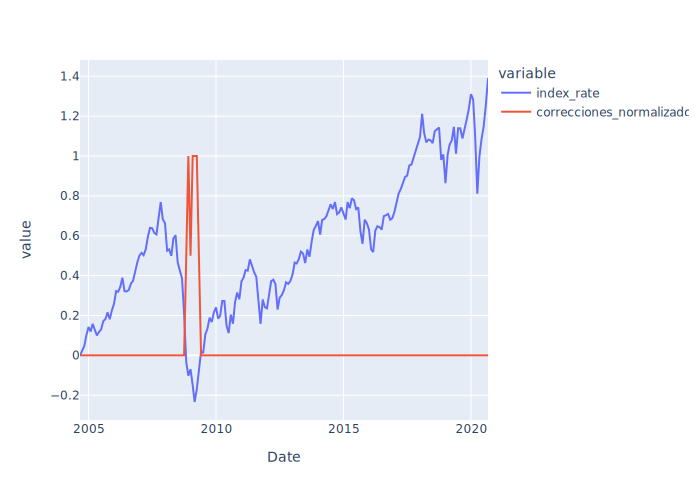

In [4]:
df_plot = pd.DataFrame(index=df.index)

df_plot['index_rate'] = index_rate
scale = correcciones.max() if correcciones.max() != 0 else 1
df_plot['correcciones_normalizado'] = correcciones / scale

fig = px.line(df_plot)
fig.show('svg')

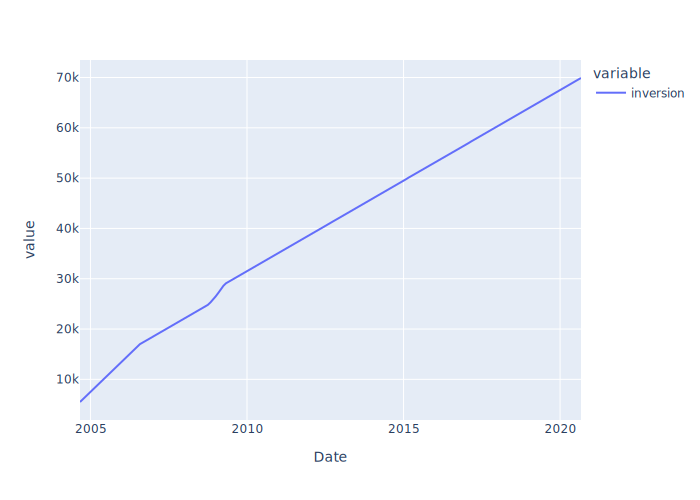

In [5]:
# inversión mensual
inversion_mensual_primero = np.ones((12*aportaciones_periodicas['tiempo'],)) * aportaciones_periodicas['cantidad']
inversion_mensual_primero[0] += aportacion_inicial
inversion_mensual_siguientes = np.ones(round(12*tiempo_restante),) * aportaciones_periodicas_restantes
inversion_mensual = np.concatenate((inversion_mensual_primero, inversion_mensual_siguientes), axis=0) + correcciones
inversion = inversion_mensual.cumsum()

df_plot = pd.DataFrame(index=df.index)

df_plot['inversion'] = inversion

fig = px.line(df_plot)
fig.show('svg')

In [6]:
print(f"                    Aportación inicial : {aportacion_inicial}")
aportacion_primeros = 12 * aportaciones_periodicas['tiempo'] * aportaciones_periodicas['cantidad']
print(f"Aportacion periodica ( primeros años ) : {aportacion_primeros}  \t({aportaciones_periodicas['tiempo']} años)")
aportacion_siguientes = round(12 * tiempo_restante) * aportaciones_periodicas_restantes
print(f"Aportacion periodica (siguientes años) : {aportacion_siguientes} \t({tiempo_restante} años)")
print(f"                          Correcciones : {correcciones.sum()}")
print( "---------------------------------------------------------------------------------------------")
aportacion_final = aportacion_inicial + aportacion_primeros + aportacion_siguientes + correcciones.sum()
print(f"                       Aportación total: {aportacion_final}")

                    Aportación inicial : 5000
Aportacion periodica ( primeros años ) : 12000  	(2 años)
Aportacion periodica (siguientes años) : 50700 	(14.083333333333332 años)
                          Correcciones : 2200
---------------------------------------------------------------------------------------------
                       Aportación total: 69900


In [7]:
# Compra de participaciones
participaciones = inversion_mensual / df['Open']
rentabilidad = participaciones.cumsum() * df['Open']

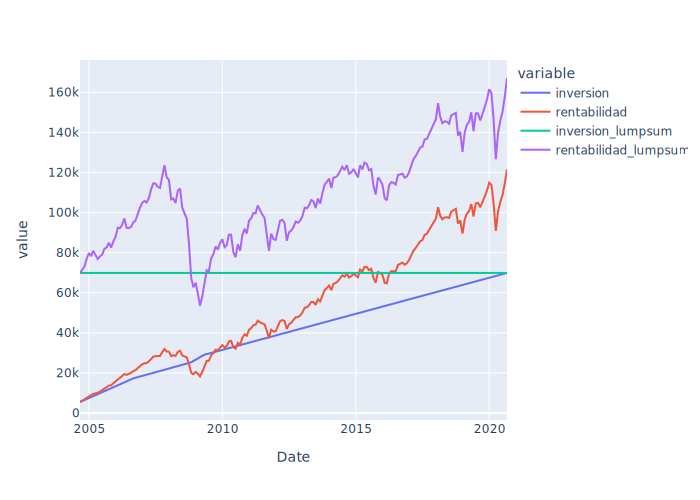

In [8]:
df_plot = pd.DataFrame(index=df.index)

df_plot['inversion'] = inversion
df_plot['rentabilidad'] = rentabilidad

# LUMP SUM
inversion_lumpsum = np.zeros((len(df.index)))
inversion_lumpsum[0] = inversion[-1]
participaciones_lumpsum = inversion_lumpsum / df['Open']
rentabilidad_lumpsum = participaciones_lumpsum.cumsum() * df['Open']
df_plot['inversion_lumpsum'] = inversion_lumpsum.cumsum()
df_plot['rentabilidad_lumpsum'] = rentabilidad_lumpsum

fig = px.line(df_plot)
fig.show('svg')

In [9]:
# Resultados rentabilidad
anyos_inversion = len(df.index)/12
print(f"[*] Años de inversion: {anyos_inversion}")
print()
lumpsum_final = rentabilidad_lumpsum[-1] / inversion_lumpsum.cumsum()[-1] -1
print("   LUMP_SUM: {0} ({1} anual)".format(
    lumpsum_final,
    lumpsum_final / anyos_inversion
))
final = rentabilidad[-1] / inversion[-1] -1
print("MY PROPOSAL: {0} ({1} anual)".format(
    final,
    final / anyos_inversion
))

[*] Años de inversion: 16.083333333333332

   LUMP_SUM: 1.391438541459023 (0.0865143134585921 anual)
MY PROPOSAL: 0.7396733168183349 (0.04599005078663223 anual)
